In [ ]:
!pip install kagglehub torchvision --quiet


In [ ]:
pip install kagglehub

Epoch [1/20] - Loss: 7154.2440
Epoch [2/20] - Loss: 6898.2294
Epoch [3/20] - Loss: 6804.8604
Epoch [4/20] - Loss: 6749.9724
Epoch [5/20] - Loss: 6710.0214
Epoch [6/20] - Loss: 6686.4912
Epoch [7/20] - Loss: 6667.6995
Epoch [8/20] - Loss: 6655.1325
Epoch [9/20] - Loss: 6644.5394
Epoch [10/20] - Loss: 6633.2455
Epoch [11/20] - Loss: 6622.7069
Epoch [12/20] - Loss: 6611.7477
Epoch [13/20] - Loss: 6602.7638
Epoch [14/20] - Loss: 6594.0472
Epoch [15/20] - Loss: 6586.4260
Epoch [16/20] - Loss: 6579.9824
Epoch [17/20] - Loss: 6574.0064
Epoch [18/20] - Loss: 6570.9508
Epoch [19/20] - Loss: 6566.2246
Epoch [20/20] - Loss: 6562.1004


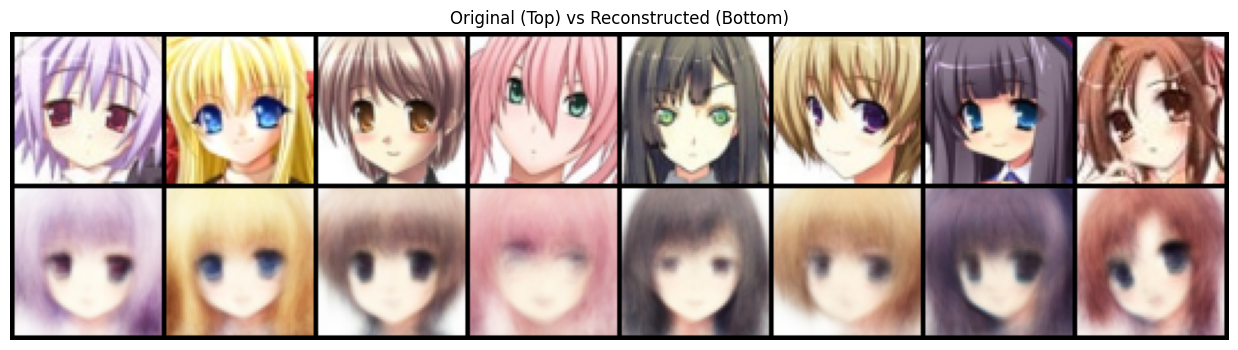

In [ ]:
# 1. Import Library
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
from PIL import Image
import matplotlib.pyplot as plt
import kagglehub

# 2. Unduh dataset dari KaggleHub
dataset_path = kagglehub.dataset_download("splcher/animefacedataset")
image_folder = os.path.join(dataset_path, "images")

# 3. Preprocessing image
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# 4. Dataset kustom (karena tidak ada folder kelas)
class AnimeFaceDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, 0  # dummy label

# 5. DataLoader
dataset = AnimeFaceDataset(image_folder, transform=transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# 6. Definisi Model VAE
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 64 * 3, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(512, 128)
        self.fc_logvar = nn.Linear(512, 128)
        self.decoder = nn.Sequential(
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 64 * 64 * 3),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

# 7. Loss Function
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 64*64*3), reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div

# 8. Training Loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 20

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for imgs, _ in dataloader:
        imgs = imgs.to(device)
        optimizer.zero_grad()
        recon, mu, logvar = model(imgs)
        loss = vae_loss(recon, imgs, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(dataloader.dataset)
    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.4f}")

# 9. Visualisasi Rekonstruksi
model.eval()
with torch.no_grad():
    imgs, _ = next(iter(dataloader))
    imgs = imgs.to(device)
    recon, _, _ = model(imgs)
    recon = recon.view(-1, 3, 64, 64)
    grid = make_grid(torch.cat([imgs[:8], recon[:8]]), nrow=8)
    plt.figure(figsize=(16, 4))
    plt.imshow(grid.permute(1, 2, 0).cpu())
    plt.title("Original (Top) vs Reconstructed (Bottom)")
    plt.axis("off")
    plt.show()
